In [ ]:
# Projeto Marinha do Brasil

# Autor: Natanael Junior (natmourajr@gmail.com)
# Laboratorio de Processamento de Sinais - UFRJ

In [1]:
import os
import pickle
import numpy as np
import time

from sklearn.decomposition import PCA
from sklearn.externals import joblib

init_time = time.time()

m_time = time.time()
print 'Time to import all libraries: '+str(m_time-init_time)+' seconds'

outputpath = os.environ['OUTPUTDATAPATH']
main_analysis_path = os.environ['SONAR_WORKSPACE']
log_analysis_path = os.environ['PACKAGE_OUTPUT']
result_analysis_path = os.environ['PACKAGE_OUTPUT']+'/PCALinear'
pict_results_path = os.environ['PACKAGE_OUTPUT']+'/PCALinear/picts'
files_results_path = os.environ['PACKAGE_OUTPUT']+'/PCALinear/output_files'

# Read data
# Check if LofarData has created...
m_time = time.time()


subfolder = '4classes'
n_pts_fft = 1024
decimation_rate = 3

if(not os.path.exists(outputpath+'/'+'LofarData_%s_%i_fft_pts_%i_decimation_rate.jbl'%(
            subfolder,n_pts_fft,decimation_rate))):
    print outputpath+'/'+'LofarData_%s_%i_fft_pts_%i_decimation_rate.jbl'%(
        subfolder,n_pts_fft,decimation_rate)+' doesnt exist...please create it'
    exit()
    
#Read lofar data
[data,class_labels] = joblib.load(outputpath+'/'+
                                  'LofarData_%s_%i_fft_pts_%i_decimation_rate.jbl'%(
            subfolder,n_pts_fft,decimation_rate))
m_time = time.time()-m_time
print 'Time to read data file: '+str(m_time)+' seconds'

Time to import all libraries: 7.79628753662e-05 seconds
Time to read data file: 2.10669398308 seconds


In [2]:
# Get data in correct format
from keras.utils import np_utils

# create a full data vector
all_data = {};
all_trgt = {};

for iclass, class_label in enumerate(class_labels):
    for irun in range(len(data[iclass])):
        if len(all_data) == 0:
            all_data = data[iclass][irun]['Signal']
            all_trgt = (iclass)*np.ones(data[iclass][irun]['Signal'].shape[1])
        else:
            all_data = np.append(all_data,data[iclass][irun]['Signal'],axis=1)
            all_trgt = np.append(all_trgt,(iclass)*np.ones(data[iclass][irun]
                                                           ['Signal'].shape[1]),axis=0)

all_data = all_data.transpose()

# turn targets in sparse mode
trgt_sparse = np_utils.to_categorical(all_trgt)

Using Theano backend.
/Users/natmourajr/.virtualenvs/kerasenv/lib/python2.7/site-packages/keras/utils/np_utils.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y = np.zeros((len(y), nb_classes))
/Users/natmourajr/.virtualenvs/kerasenv/lib/python2.7/site-packages/keras/utils/np_utils.py:16: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y[i, y[i]] = 1.


In [99]:
# Train Process
from Functions import LogFunctions as log

# Create a entry in log file
m_log = log.LogInformation()
date = m_log.CreateLogEntry(package_name="PreProcessing",analysis_name='PCALinear')

# Create a train information file
n_folds = 10
n_inits = 2
norm = 'mapstd'

train_info = {}
train_info['n_folds'] = n_folds
train_info['norm'] = norm
train_info['n_inits'] = n_inits

train_info_name = result_analysis_path+'/train_info_files'+'/'+date+'_train_info.jbl'
pca_file_name = result_analysis_path+'/output_files'+'/'+date+'_pcas_files.jbl'

from sklearn import cross_validation
from sklearn import preprocessing
from sklearn.decomposition import PCA

CVO = cross_validation.StratifiedKFold(all_trgt, train_info['n_folds'])
CVO = list(CVO)
train_info['CVO'] = CVO

joblib.dump([train_info],train_info_name,compress=9)

n_pcas = all_data.shape[1]
pca = {}
pca_energy = np.zeros([train_info['n_folds'],n_pcas])
bins = np.linspace(0,n_pcas-1,n_pcas)

for ifold in range(train_info['n_folds']):
    train_id, test_id = CVO[ifold]
    
    # normalize data based in train set
    if train_info['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])
        
    norm_all_data = scaler.transform(all_data)
    
    pca[ifold] = PCA(n_components=norm_all_data.shape[1])
    pca[ifold].fit(norm_all_data[train_id,:])
    pca_energy[ifold,:] = pca[ifold].explained_variance_/np.sum(pca[ifold].explained_variance_)

joblib.dump([pca,pca_energy],pca_file_name,compress=9)

['/Users/natmourajr/Workspace/Doutorado/SonarAnalysis/Results/PreProcessing/PCALinear/output_files/2016_08_18_01_37_01_pcas_files.jbl']

In [3]:
# Read log files
from Functions import LogFunctions as log
mlog = log.LogInformation()
log_entries = mlog.RecoverLogEntries(package_name="PreProcessing")
print log_entries

{0: {'date': '2016_08_17_16_23_03', 'package': 'PCALinear'}, 1: {'date': '2016_08_17_16_23_38', 'package': 'PCALinear'}, 2: {'date': '2016_08_17_16_28_06', 'package': 'PCALinear'}, 3: {'date': '2016_08_17_16_28_58', 'package': 'PCALinear'}, 4: {'date': '2016_08_17_16_29_40', 'package': 'PCALinear'}, 5: {'date': '2016_08_17_16_32_09', 'package': 'PCALinear'}, 6: {'date': '2016_08_17_16_33_00', 'package': 'PCALinear'}, 7: {'date': '2016_08_17_16_35_15', 'package': 'PCALinear'}, 8: {'date': '2016_08_17_16_39_23', 'package': 'PCALinear'}, 9: {'date': '2016_08_17_16_41_45', 'package': 'PCALinear'}, 10: {'date': '2016_08_17_16_43_21', 'package': 'PCALinear'}, 11: {'date': '2016_08_17_16_50_23', 'package': 'PCALinear'}, 12: {'date': '2016_08_17_16_55_42', 'package': 'PCALinear'}, 13: {'date': '2016_08_17_16_57_01', 'package': 'PCALinear'}, 14: {'date': '2016_08_17_17_00_52', 'package': 'PCALinear'}, 15: {'date': '2016_08_17_17_01_58', 'package': 'PCALinear'}, 16: {'date': '2016_08_17_17_18_02

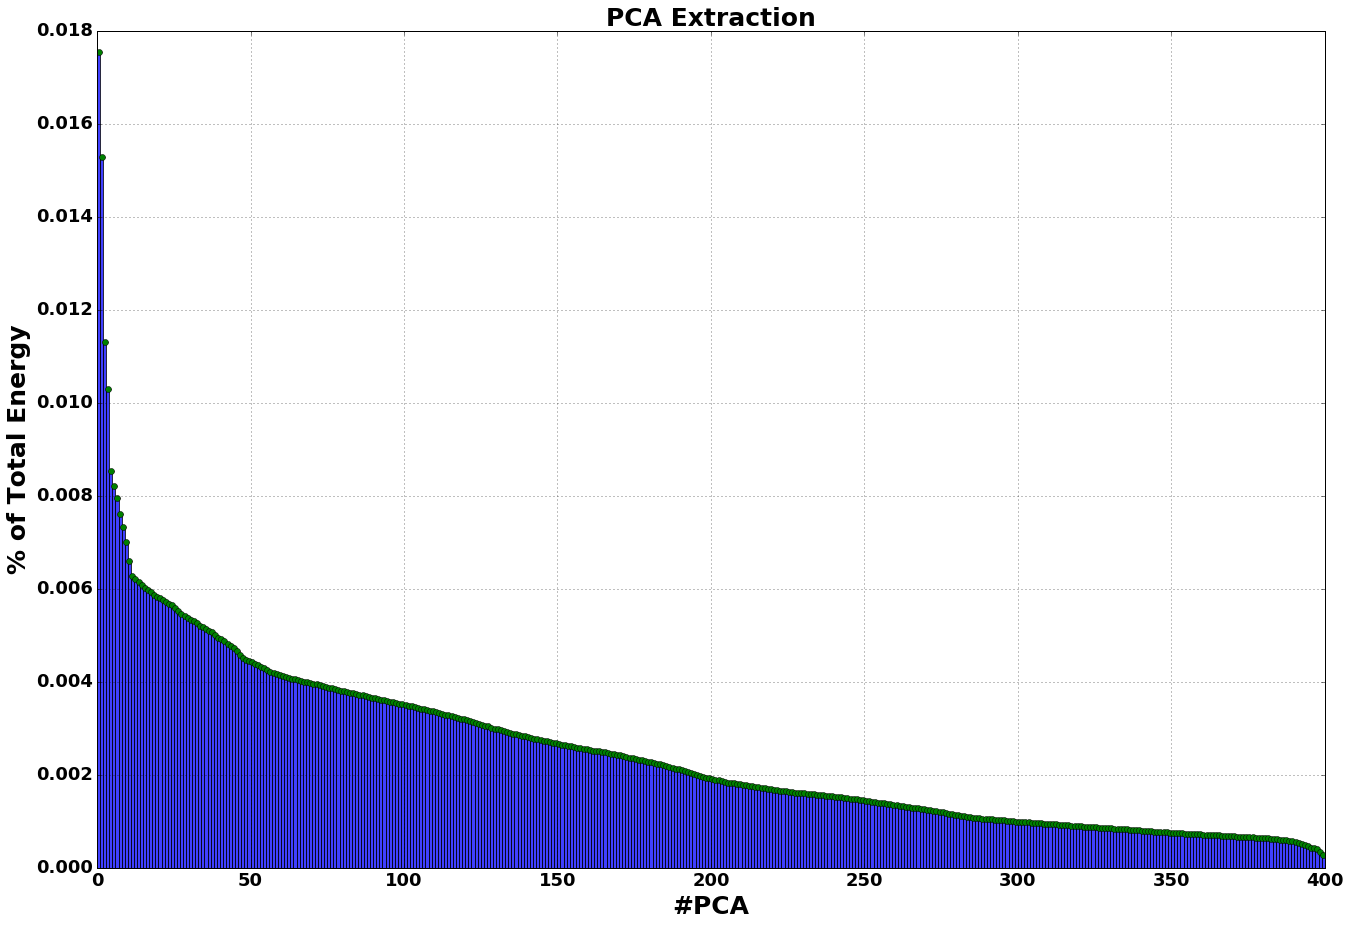

In [101]:
# Analysis Process
# Plot each PCA energy (distribution)
choose_date = '2016_08_18_01_37_01'

# load train info
train_info_name = result_analysis_path+'/train_info_files'+'/'+choose_date+'_train_info.jbl'
train_info = joblib.load(train_info_name)
train_info = train_info[0]

# load pca file
pca_file_name = result_analysis_path+'/output_files'+'/'+date+'_pcas_files.jbl'
[pca,pca_energy] = joblib.load(pca_file_name)

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['ytick.labelsize'] = 18

%matplotlib inline

fig, subplot_array = plt.subplots(nrows=1, ncols=1,figsize=(22,15))
plt.bar(bins,np.mean(pca_energy.T,1),
        width=1, yerr=np.var(pca_energy.T,1),
        facecolor='b',alpha=0.75,label='Energy of PCAi')
plt.errorbar(bins+0.5, np.mean(pca_energy.T,1),
             yerr=np.var(pca_energy.T,1),ecolor='r',fmt='o')

plt.grid()
m_fontsize = 25
plt.title('PCA Extraction', fontsize= m_fontsize, fontweight='bold')
plt.ylabel('% of Total Energy', fontsize= m_fontsize, fontweight='bold')
plt.xlabel('#PCA', fontsize= m_fontsize, fontweight='bold')



([<matplotlib.axis.XTick at 0x115a25a50>,
 <a list of 21 Text xticklabel objects>)

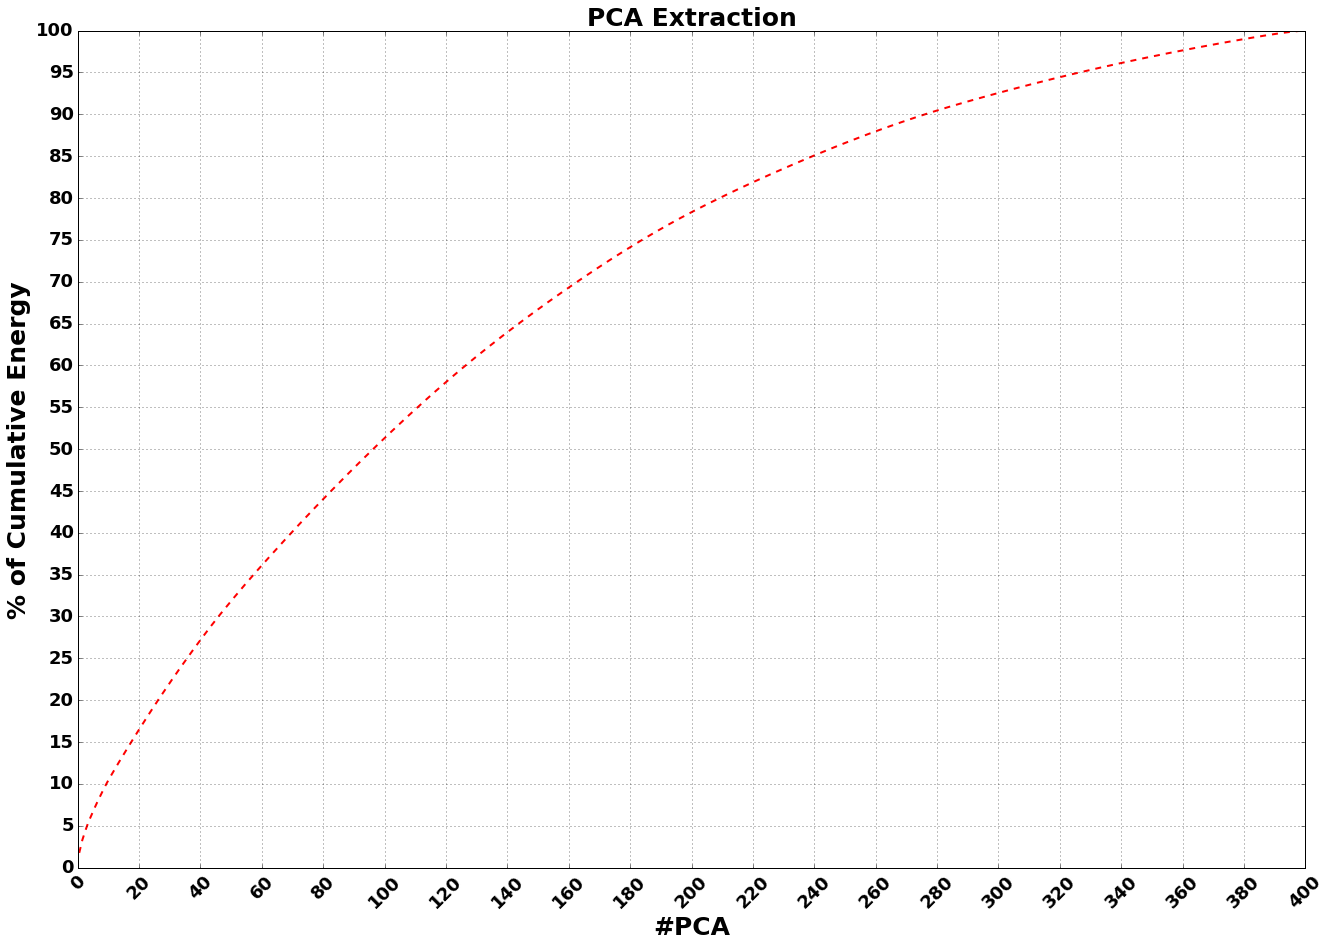

In [102]:
# Analysis Process
# Plot cumulative PCA energy
choose_date = '2016_08_18_01_37_01'

# load train info
train_info_name = result_analysis_path+'/train_info_files'+'/'+choose_date+'_train_info.jbl'
train_info = joblib.load(train_info_name)
train_info = train_info[0]

# load pca file
pca_file_name = result_analysis_path+'/output_files'+'/'+date+'_pcas_files.jbl'
[pca,pca_energy] = joblib.load(pca_file_name)

import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D

plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.handlelength'] = 3
plt.rcParams['legend.borderpad'] = 0.3
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['ytick.labelsize'] = 18

%matplotlib inline

fig, subplot_array = plt.subplots(nrows=1, ncols=1,figsize=(22,15))
plt.plot(bins+0.5,100.*np.cumsum(np.mean(pca_energy.T,1)),'r--')
   
plt.grid()
m_fontsize = 25
plt.title('PCA Extraction', fontsize= m_fontsize, fontweight='bold')
plt.ylabel('% of Cumulative Energy', fontsize= m_fontsize, fontweight='bold')
plt.xlabel('#PCA', fontsize= m_fontsize, fontweight='bold')

plt.yticks([x for x in range(0,101,5)],[x for x in range(0,101,5)])
plt.xticks([x for x in range(0,401,20)],[x for x in range(0,401,20)],rotation=45)

In [ ]:
# Analysis Process

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import SGD
import keras.callbacks as callbacks
from keras.utils import np_utils
from keras.layers import Merge

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

# Plot Classification Eff from NN
choose_date = '2016_08_18_01_37_01'

# load train info
train_info_name = result_analysis_path+'/train_info_files'+'/'+choose_date+'_train_info.jbl'
train_info = joblib.load(train_info_name)
train_info = train_info[0]

# load pca file
pca_file_name = result_analysis_path+'/output_files'+'/'+choose_date+'_pcas_files.jbl'
[pca,pca_energy] = joblib.load(pca_file_name)

classifiers = {}

eff = np.zeros([4,train_info['n_folds'],all_data.shape[1]])

for ifold in range(train_info['n_folds']):
    classifiers[ifold] = {}
    
    train_id, test_id = train_info['CVO'][ifold]
    
    # normalize data based in train set
    if train_info['norm'] == 'mapstd':
        scaler = preprocessing.StandardScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapstd_rob':
        scaler = preprocessing.RobustScaler().fit(all_data[train_id,:])
    elif train_info['norm'] == 'mapminmax':
        scaler = preprocessing.MinMaxScaler().fit(all_data[train_id,:])
        
    norm_all_data = scaler.transform(all_data)
    proj_data = pca[ifold].transform(norm_all_data)
    
    for ipca in range(1,41):       
        train_data = proj_data[:,0:ipca]
        
        best_init = 0
        best_loss = 999
        for i_init in range(train_info['n_inits']):
            print ('Processing: Fold %i of %i - PCA %i of %i - Init %i of %i'%(
                    ifold+1,train_info['n_folds'], 
                    ipca, proj_data.shape[1],
                    i_init+1, train_info['n_inits']))
            model = Sequential()
            model.add(Dense(train_data.shape[1],
                            input_dim=train_data.shape[1],
                            init='identity',trainable=False))
            model.add(Activation('linear'))
            model.add(Dense(1, input_dim=train_data.shape[1], init='uniform'))
            model.add(Activation('tanh'))
            model.add(Dense(trgt_sparse.shape[1], init='uniform')) 
            model.add(Activation('tanh'))
            sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
            model.compile(loss='mean_squared_error',
                          optimizer=sgd,
                          metrics=['accuracy'])
            earlyStopping = callbacks.EarlyStopping(monitor='val_loss', patience=25, 
                                            verbose=0, mode='auto')
            # Train model
            init_trn_desc = model.fit(train_data[train_id], trgt_sparse[train_id], 
                                      nb_epoch=50, batch_size=8, 
                                      callbacks=[earlyStopping], 
                                      verbose=0, 
                                      validation_data=(train_data[test_id],
                                                       trgt_sparse[test_id]), 
                                      shuffle=True)
            if np.min(init_trn_desc.history['val_loss']) < best_loss:
                    best_init = i_init
                    best_loss = np.min(init_trn_desc.history['val_loss'])
                    classifiers[ifold][ipca] = model
        # get the best output
        output = classifiers[ifold][ipca].predict(train_data)
        all_output = np.argmax(output,axis=1)
        cm = confusion_matrix(all_trgt[test_id], all_output[test_id])
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        for iclass in range(4):
            eff[iclass, ifold, ipca] = cm[iclass,iclass]
        
eff_file_name = result_analysis_path+'/output_files'+'/'+choose_date+'_eff_file.jbl'
joblib.dump([eff],pca_file_name,compress=9)

In [98]:
eff[1,0,2]

0.87016969944796563